<a href="https://colab.research.google.com/github/cSAS3/NIBB-CU-Hackason-2025/blob/main/Kingfisher_Auto_Crop_Script_seine_a_shintani_250718_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
[INFO] Loaded image: 2048×1366px


100%|██████████| 6.25M/6.25M [00:00<00:00, 155MB/s]



0: 448x640 2 birds, 327.5ms
Speed: 13.7ms preprocess, 327.5ms inference, 31.6ms postprocess per image at shape (1, 3, 448, 640)
[INFO] Expanded crop box: (257,273)–(1438,1340)
[SAVE] /content/crop_original.jpg
[SAVE] /content/crop_512.jpg

[DISPLAY] Cropped & resized image (512×512)


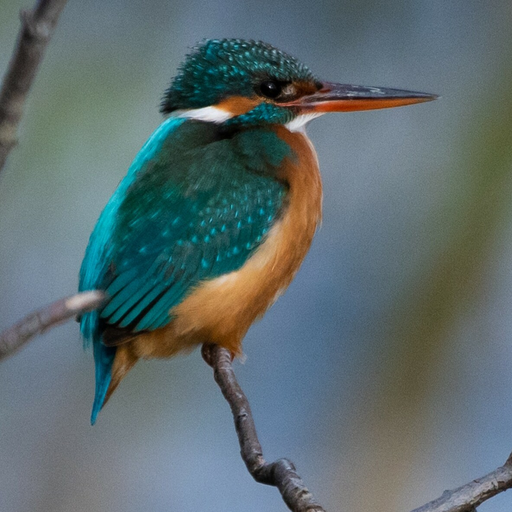

In [ ]:
# -----------------------------------------------------------
# Kingfisher Auto‑Cropper
# (c) 2025  -- MIT License  |  Requires: Python ≥3.9
# -----------------------------------------------------------
# 0. ライブラリのインストール（初回のみ）
#    Colab ではインターネットが通るので pip で取得できます
!pip -q install ultralytics pillow opencv-python-headless

# 1. 必要なモジュールを読み込む
from ultralytics import YOLO                # 物体検出モデル
import cv2                                   # 画像読み込み・描画
from PIL import Image                        # リサイズ・保存
import numpy as np                           # 数値計算
from pathlib import Path                     # パス操作

# 2. パラメータ設定  -----------------------------------------
IMAGE_PATH = "/content/339582411.jpg"                # ←アップロードした画像名
MARGIN_RATIO = 0.20                          # バウンディングボックスを上下左右20%ずつ拡張
OUTPUT_ORIG = "/content/crop_original.jpg"
OUTPUT_512  = "/content/crop_512.jpg"

# 3. 画像読み込み ＆ サイズ取得 -----------------------------
img_bgr  = cv2.imread(IMAGE_PATH)
assert img_bgr is not None, f"画像 {IMAGE_PATH} が見つかりません"
h, w, _  = img_bgr.shape
print(f"[INFO] Loaded image: {w}×{h}px")

# 4. YOLOv8 – 事前学習済みモデルをロード --------------------
#    'yolov8n' は最小モデル (nano)。精度を上げたい場合は 'yolov8m' や 'yolov8x' も可
model = YOLO("yolov8n.pt")                   # 初回は重み (~6 MB) を自動 DL

# 5. 物体検出の実行 ----------------------------------------
#    conf=0.25 は信頼度下限, classes=[14] は COCO class_id=14 ('bird')
results = model(img_bgr, conf=0.25, classes=[14])

# 6. 最も確信度の高い検出を 1 つ選ぶ -----------------------
if not results or len(results[0].boxes) == 0:
    raise RuntimeError("鳥が検出できませんでした。画像を確認してください")

# Ultralytics 結果オブジェクトは PyTorch Tensor。cpu() で NumPy へ
boxes = results[0].boxes
scores = boxes.conf.cpu().numpy()            # 信頼度
xyxy   = boxes.xyxy.cpu().numpy()            # [x1, y1, x2, y2]
best   = scores.argmax()
x1, y1, x2, y2 = xyxy[best]                  # 最優秀1件

# 7. バウンディングボックスを周辺拡張 -----------------------
#    拡張後も画像領域内に収まるよう min/max を取る
box_w, box_h = x2 - x1, y2 - y1
dx = box_w * MARGIN_RATIO
dy = box_h * MARGIN_RATIO

x1e = max(int(x1 - dx), 0)
y1e = max(int(y1 - dy), 0)
x2e = min(int(x2 + dx), w - 1)
y2e = min(int(y2 + dy), h - 1)

print(f"[INFO] Expanded crop box: ({x1e},{y1e})–({x2e},{y2e})")

# 8. 元解像度で切り出し & 保存 ------------------------------
crop_bgr = img_bgr[y1e:y2e, x1e:x2e]
cv2.imwrite(OUTPUT_ORIG, crop_bgr)
print(f"[SAVE] {OUTPUT_ORIG}")

# 9. 512×512 にリサイズし保存 ------------------------------
crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)     # PIL は RGB 前提
img_pil  = Image.fromarray(crop_rgb)
img_512  = img_pil.resize((512, 512), Image.LANCZOS)     # 高品質補間
img_512.save(OUTPUT_512)
print(f"[SAVE] {OUTPUT_512}")

# 10. Colab 上でサムネイル表示（任意） --------------------
from IPython.display import display
print("\n[DISPLAY] Cropped & resized image (512×512)")
display(img_512)
